In [1]:
import os
import random
import string
from collections import Counter, defaultdict
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils as nn_utils
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models

In [2]:
# Define paths
images_path = '/kaggle/input/d/eeshawn/flickr30k/flickr30k_images'
captions_file = '/kaggle/input/d/eeshawn/flickr30k/captions.txt'

In [3]:
# Creates a dictionary, with the image name as the key, and the caption as the value
captions = defaultdict(list)
with open(captions_file, 'r') as f:
    next(f)  # Skip the header
    for line in f:
        image, caption = line.strip().split(',', 1)
        captions[image].append(caption)

# Example caption
captions['1000092795.jpg']

['0,Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 '1,Two young  White males are outside near many bushes .',
 '2,Two men in green shirts are standing in a yard .',
 '3,A man in a blue shirt standing in a garden .',
 '4,Two friends enjoy time spent together .']

In [4]:
# Preprocess captions and clean the text up
def clean_caption(caption):
    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    # Remove words with numbers and words of length 1
    # If the word is of length 1, or the word contains a digit, remove it from the cpation
    caption = ' '.join([word for word in caption.split() if len(word) > 1 and not any(char.isdigit() for char in word)])
    # Convert to lowercase
    caption = caption.lower()
    return caption

#Cleans all captions in captions dictionary
for image in captions:
    # Loops over all strings, and cleans the captions
    captions[image] = [clean_caption(caption) for caption in captions[image]]

In [5]:
# Define image transformation - with augmentations
# Resize((256, 256)): Resizes the image to a slightly larger size than the target.
# RandomCrop((224, 224)): Randomly crops the image to the target size, introducing positional variance.
# RandomHorizontalFlip(p=0.5): Flips the image horizontally with a 50% probability.
# ColorJitter: Randomly changes brightness, contrast, saturation, and hue.
# RandomRotation: Randomly rotates the image by up to 10 degrees.
# RandomAffine: Applies random affine transformations (translation and scaling).
# ToTensor(): Converts the image to a tensor.
# Normalize: Normalizes the image using ImageNet mean and standard deviation.
# Lambda: Ensures the image has 3 channels (as in your original pipeline).
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to slightly larger than target size
    transforms.RandomCrop((224, 224)),  # Random crop to target size
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jittering
    transforms.RandomRotation(degrees=10, interpolation=InterpolationMode.BILINEAR),  # Random rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Random affine transformation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize to ImageNet stats
    transforms.Lambda(lambda x: x[:3, :, :]),  # Ensure the image has 3 channels
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x[:3, :, :]),
])

# Load image function helper
def load_image(image_file):
    image = Image.open(os.path.join(images_path, image_file)).convert('RGB')
    image = transform(image)
    return image

In [6]:
# Build vocabulary count to omit rare words
word_counter = Counter()
for image, caption_list in captions.items():
    # Loops through list of strings
    for caption in caption_list:
        word_counter.update(caption.split())

In [7]:
# Create dictionaries for words and include words that only appear a number of times above the threshold
vocab_threshold = 3
vocab = [word for word, count in word_counter.items() if count > vocab_threshold]
vocab_size = len(vocab) + 4  # Including <PAD>, <START>, <END>, <UNK>

In [8]:
# Create dictionary mapping stoi and itos
stoi = {word: idx + 4 for idx, word in enumerate(vocab)}
stoi['<PAD>'] = 0
stoi['<START>'] = 1
stoi['<END>'] = 2
stoi['<UNK>'] = 3
itos = {idx: word for word, idx in stoi.items()}

In [9]:
# Helper functions
def encode_caption(caption):
    # Default entry for dictionary.get()
    encoded = [stoi['<START>']] + [stoi.get(word, stoi['<UNK>']) for word in caption.split()] + [stoi['<END>']]
    return encoded

def decode_caption(encoded_caption):
    # Default entry for dictionary.get()
    return ' '.join([itos.get(idx, '<UNK>') for idx in encoded_caption])

def pad_caption(caption, max_length):
    # This actually pads one less than the max, which is not intended. But, we will keep this anyways
    return caption + [stoi['<PAD>']] * (max_length - len(caption))

In [10]:
# Calculate the max length of the captions
# To unpack this, we are looping over the defaultdict captions. We get the list of strings called caption_list, and loop over all lists of strings in captions, and also loop over all captions in the list
# This is a very complex string comprehension
# We add 2 to the max_length, so that there will always be space for atleast one END token, and one PAD token
max_length = max(len(caption.split()) for caption_list in captions.values() for caption in caption_list) + 2
max_length

74

In [11]:
# Loops over all image keys, all caption lists, all captions in caption lists, encodes them, and pads them
encoded_captions = defaultdict(list)

for image in captions:
    for caption in captions[image]:
        encoded = encode_caption(caption)
        padded = pad_caption(encoded, max_length)
        encoded_captions[image].append(padded)
        
# encoded_captions['1000092795.jpg'][0]

In [12]:
# Function to create input and target sequences
# Here, we are cutting off the input sequence by 1 token, so that the target sequence won't be incorrect
def create_sequences(encoded_caption):
    input_sequence = encoded_caption[:-1]
    target_sequence = encoded_caption[1:]
    return input_sequence, target_sequence

In [13]:
# Create input and target sequences for all captions
input_sequences = defaultdict(list)
target_sequences = defaultdict(list)

# Looping over all image key, list of captions
for image, caption_list in encoded_captions.items():
    for caption in caption_list:
        # Loop through all captions in all caption_lists, and create the corresponding token lists
        input_seq, target_seq = create_sequences(caption)
        # Create another defaultdict() that allows for indexing of the processed list tokens
        input_sequences[image].append(input_seq)
        target_sequences[image].append(target_seq)

In [14]:
# Creating randomized batches
# List of image keys
image_keys = list(captions.keys())
torch.manual_seed(1337)
# Shuffle the iamge keys
shuffled_indices = torch.randperm(len(image_keys)).tolist()
image_keys = [image_keys[i] for i in shuffled_indices]

In [15]:
# Split the keys (80% training, 20% validation)
split_index = int(0.8 * len(image_keys))
train_keys = image_keys[:split_index]
val_keys = image_keys[split_index:]

In [16]:
# Create train and validation sets
train_captions = {key: captions[key] for key in train_keys}
val_captions = {key: captions[key] for key in val_keys}
train_input_sequences = {key: input_sequences[key] for key in train_keys}
val_input_sequences = {key: input_sequences[key] for key in val_keys}
train_target_sequences = {key: target_sequences[key] for key in train_keys}
val_target_sequences = {key: target_sequences[key] for key in val_keys}

In [17]:
# Randomized batch sampling
# def create_batch(caption_dict, input_seq_dict, target_seq_dict, batch_size):
#     images_batch = []
#     input_captions_batch = []
#     target_captions_batch = []
    
#     selected_images = random.sample(list(caption_dict.keys()), batch_size)
#     for image in selected_images:
#         # Pick a random index from one of the caption lists
#         selected_caption_idx = random.randint(0, len(caption_dict[image]) - 1)
#         # Add the corresponding image caption
#         input_captions_batch.append(input_seq_dict[image][selected_caption_idx])
#         # Get the corresponding target_caption
#         target_captions_batch.append(target_seq_dict[image][selected_caption_idx])
#         # Add the image to the corresponding image to the image set
#         images_batch.append(load_image(image))
    
#     images_batch = torch.stack(images_batch)
#     input_captions_batch = torch.tensor(input_captions_batch)
#     target_captions_batch = torch.tensor(target_captions_batch)
    
#     return images_batch, input_captions_batch, target_captions_batch


In [18]:
# Non-randomzed batching, indexed by image_keys
def create_batch(caption_dict, input_seq_dict, target_seq_dict, batch_size, image_keys):
    images_batch = []
    input_captions_batch = []
    target_captions_batch = []
    
    # Loop over all image keys
    for image in image_keys[:batch_size]:
        # Pick a random caption for the image
        selected_caption_idx = random.randint(0, len(caption_dict[image]) - 1)
        input_captions_batch.append(input_seq_dict[image][selected_caption_idx])
        target_captions_batch.append(target_seq_dict[image][selected_caption_idx])
        images_batch.append(load_image(image))
    
    # Convert to expected shapes
    images_batch = torch.stack(images_batch)
    input_captions_batch = torch.tensor(input_captions_batch)
    target_captions_batch = torch.tensor(target_captions_batch)
    
    return images_batch, input_captions_batch, target_captions_batch

In [19]:
# Example usage of function
batch_size = 4
batch_keys = train_keys[0:0+batch_size]
image_batch, caption_batch, label_batch = create_batch(train_captions, train_input_sequences, train_target_sequences, len(batch_keys), batch_keys)
print(image_batch.shape)
print(caption_batch.shape)
print(label_batch.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4, 73])
torch.Size([4, 73])


Training example:


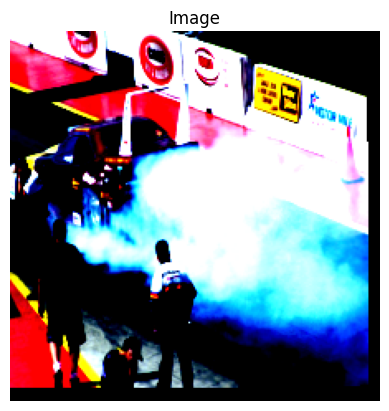

Input Caption: <START> nothing like hot day at the races and smelling the rubber burn <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: nothing like hot day at the races and smelling the rubber burn <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Validation example:


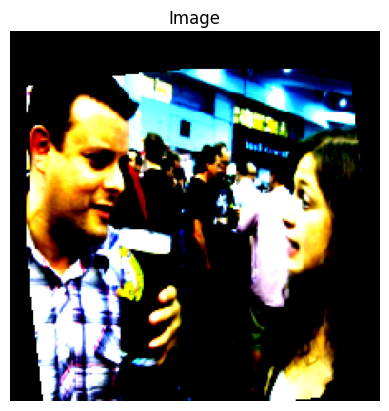

Input Caption: <START> man with beer in his hand listens to woman talk <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: man with beer in his hand listens to woman talk <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [20]:
def visualize_example(caption_dict, input_seq_dict, target_seq_dict):
    
    # Select a random image
    random_image = random.choice(list(caption_dict.keys()))
    
    # Select a random caption index for the chosen image
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    
    # Load the image
    image_tensor = load_image(random_image)
    image_array = image_tensor.permute(1, 2, 0).numpy()
    
    # Get the corresponding caption inputs and targets
    input_caption_encoded = input_seq_dict[random_image][caption_idx]
    target_caption_encoded = target_seq_dict[random_image][caption_idx]
    input_caption = decode_caption(input_caption_encoded)
    target_caption = decode_caption(target_caption_encoded)
    
    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    # Print the input and target captions
    print(f"Input Caption: {input_caption}")
    print(f"Target Caption: {target_caption}")

# Visualize one of the examples
print("Training example:")
visualize_example(train_captions, train_input_sequences, train_target_sequences)

print("Validation example:")
visualize_example(val_captions, val_input_sequences, val_target_sequences)


In [21]:
# Define a residual block for MLP architecture
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size//2)
        self.norm2 = nn.LayerNorm(input_size//2)
        self.fc2 = nn.Linear(input_size//2, output_size)
        self.fc3 = nn.Linear(input_size, output_size)
        self.act = nn.ELU()

    def forward(self, x):
        x = self.act(self.norm1(x))
        skip = self.fc3(x)
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        return x + skip

In [22]:
class ConvNet(nn.Module):
    def __init__(self, dropout):
        super(ConvNet, self).__init__()
        
        # Load the pretrained ResNet50 model
        self.resnet50 = models.resnet50(pretrained=True)
        
        # Freeze all the ResNet50 layers except the last fully connected layer
        for param in self.resnet50.parameters():
            param.requires_grad = False
        for param in self.resnet50.fc.parameters():
            param.requires_grad = True
        
        # Add dropout before the final fully connected layer
        self.resnet50.fc = nn.Sequential(
            nn.Dropout(dropout),
            self.resnet50.fc
        )
    
    def forward(self, inputs):  # (224, 224, 3)
        out = self.resnet50(inputs)
        return out  # (B, 1000)

In [23]:
class Decoder(nn.Module):
    def __init__(self, channels_in, dropout, vocab_size, emb_size, hidden_size, num_layers, num_blocks):
        super(Decoder, self).__init__()
        
        self.convnet = ConvNet(dropout = dropout)

        self.linear = nn.Linear(1000, hidden_size)
        
        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = hidden_size, num_layers = num_layers, bias = False, batch_first = True)

        # Residual blocks
        self.blocks = nn.Sequential(*[ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)])

        # Activation function
        self.act = nn.ELU()
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    # Memory in will always be a matrice of zeros
    def forward(self, images, captions, mem_in):

        features = self.convnet(images) # (B, 4096)
        features = self.linear(features) # (B, hidden_size)
        features = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1) # (num_layers, B, hidden_size)

        batch_size = images.size(0)
        hidden_size = self.lstm.hidden_size
        num_layers = self.lstm.num_layers

        captions = self.embedding(captions)
        
        outputs, (hidden_out, mem_out) = self.lstm(captions, (features, mem_in))
        # x = (B, T, emb_size)
        # hidden_out = (num_layers, B, hidden_size)
        # mem_out = (num_layers, B, hidden_size)

        outputs = self.act(self.blocks(outputs))
        
        return self.fc_out(outputs) 

In [24]:
# UPDATE the model parameters here

device = torch.device(0 if torch.cuda.is_available() else 'cpu')

num_iterations = 1000

nepochs = 10

learning_rate = 1e-4

channels_in = 3

dropout = 0.4

vocab_size = len(stoi)

emb_size = 2048

hidden_size = 2048

# LSTM layers
num_layers = 2

# ResBlocks
num_blocks = 2

batch_size = 128

max_length = max_length

# Paddding 1 less, than the max_length
time_steps = max_length - 1

max_grad_norm = 5.0  # Gradient clipping threshold

In [25]:
model = Decoder(channels_in = channels_in, dropout = dropout, vocab_size = vocab_size, emb_size = emb_size, hidden_size = hidden_size, num_layers = num_layers, num_blocks = num_blocks).to(device)

memory = torch.zeros(num_layers, batch_size, hidden_size, device=device)

optimizer = optim.AdamW([
    {'params': model.linear.parameters()},
    {'params': model.embedding.parameters()},
    {'params': model.lstm.parameters()},
    {'params': model.blocks.parameters()},
    {'params': model.fc_out.parameters()}
], lr=learning_rate, weight_decay=1e-4)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs, eta_min=0)

loss_fn = nn.CrossEntropyLoss()

training_loss = []

val_loss = []

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# Calculate number of model parameters
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("This model Has %d Parameters, %d Million" % (num_model_params, num_model_params//1e6 ) )

# 154M
# 163M

This model Has 146327897 Parameters, 146 Million


In [27]:
# def calculate_average_val_loss(model, val_captions, val_input_sequences, val_target_sequences, batch_size, loss_fn, num_examples=100):
#     model.eval()
#     total_loss = 0
#     num_batches = 0
#     examples_processed = 0
    
#     with torch.no_grad():
#         while examples_processed < num_examples:
#             image_batch, caption_batch, label_batch = create_batch(val_captions, val_input_sequences, val_target_sequences, batch_size)
#             current_batch_size = image_batch.size(0)
#             image_batch = image_batch.to(device)
#             caption_batch = caption_batch.to(device)
#             label_batch = label_batch.to(device)
            
#             outputs = model(image_batch, caption_batch, memory)
#             outputs = outputs.reshape(current_batch_size * time_steps, -1)
#             label_batch = label_batch.reshape(current_batch_size * time_steps)
            
#             loss = loss_fn(outputs, label_batch)
#             total_loss += loss.item() * current_batch_size
#             examples_processed += current_batch_size
#             num_batches += 1
    
#     average_loss = total_loss / examples_processed
#     return average_loss

# # average_val_loss = calculate_average_val_loss(model, val_captions, val_input_sequences, val_target_sequences, batch_size, loss_fn)
# # print("iteration", iteration, "average val loss:", average_val_loss)

In [28]:
def calculate_average_val_loss(model, val_captions, val_input_sequences, val_target_sequences, batch_size, loss_fn):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    # Calculate the number of complete batches
    num_complete_batches = len(val_keys) // batch_size
    
    with torch.no_grad():
        for i in range(0, num_complete_batches * batch_size, batch_size):
            batch_keys = val_keys[i:i+batch_size]
            image_batch, caption_batch, label_batch = create_batch(val_captions, val_input_sequences, val_target_sequences, len(batch_keys), batch_keys)
            
            image_batch = image_batch.to(device)
            caption_batch = caption_batch.to(device)
            label_batch = label_batch.to(device)
            
            outputs = model(image_batch, caption_batch, memory)
            outputs = outputs.reshape(-1, vocab_size)
            label_batch = label_batch.reshape(-1)
            
            loss = loss_fn(outputs, label_batch)
            total_loss += loss.item()
            num_batches += 1
    
    average_loss = total_loss / num_batches if num_batches > 0 else float('inf')
    return average_loss

In [29]:
# # Training loop
# for iteration in range(num_iterations):

#     # Training
#     model.train()

#     image_batch, caption_batch, label_batch = create_batch(train_captions, train_input_sequences, train_target_sequences, batch_size)

#     image_batch = image_batch.to(device)
#     caption_batch = caption_batch.to(device)
#     label_batch = label_batch.to(device)
    
#     outputs = model(image_batch, caption_batch, memory)

#     outputs = outputs.reshape(batch_size * time_steps, -1)
#     label_batch = label_batch.reshape(batch_size * time_steps)
#     loss = loss_fn(outputs, label_batch)
#     training_loss.append(loss.item())

#     if iteration % 10 == 0: 
#         print("iteration", iteration, "training loss:", loss.item())

#     # Backward pass
#     optimizer.zero_grad()
#     loss.backward()
    
#     # Clip gradients
#     nn_utils.clip_grad_norm_(model.parameters(), max_grad_norm)
#     optimizer.step()

    
#     # Evaluate every so often
#     if iteration % 10 == 0:
        
#         model.eval()

#         image_batch, caption_batch, label_batch = create_batch(val_captions, val_input_sequences, val_target_sequences, batch_size)
    
#         image_batch = image_batch.to(device)
#         caption_batch = caption_batch.to(device)
#         label_batch = label_batch.to(device)
        
#         outputs = model(image_batch, caption_batch, memory)
        
#         outputs = outputs.reshape(batch_size * time_steps, -1)
    
#         label_batch = label_batch.reshape(batch_size * time_steps)
    
#         loss = loss_fn(outputs, label_batch)

#         val_loss.append(loss.item())
        
#         print("iteration", iteration, "val loss:", loss.item())
        
#     if iteration % 100 == 0:
#         avg_val_loss = calculate_average_val_loss(model, val_captions, val_input_sequences, val_target_sequences, batch_size, loss_fn)
#         print("------")
#         print("iteration", iteration, "avg val loss:", avg_val_loss)
#         print("------")

#     lr_scheduler.step()
    

In [ ]:
# Training loop
for epoch in range(nepochs):
    
    print("training:")
    
    # Shuffle the dataset at the beginning of each epoch (to ensure that for every epoch, the batches created are randomized)
    # We train over epochs to ensure that all data in the training_set is trained over
    random.shuffle(train_keys)
    
    # Training
    model.train()
    epoch_loss = 0
    num_batches = 0

    # This loop ensures that we always get a batch of batch_size number of elements, and iterate over all examples generated in the batch
    # In every iteration, we augment the image keys to reduce overfitting
    # Calculate the number of complete batches
    num_complete_batches = len(train_keys) // batch_size
    
    for i in range(0, num_complete_batches * batch_size, batch_size):
        batch_keys = train_keys[i:i+batch_size]
        image_batch, caption_batch, label_batch = create_batch(train_captions, train_input_sequences, train_target_sequences, len(batch_keys), batch_keys)

        image_batch = image_batch.to(device)
        caption_batch = caption_batch.to(device)
        label_batch = label_batch.to(device)
        
        outputs = model(image_batch, caption_batch, memory)

        outputs = outputs.reshape(-1, vocab_size)
        label_batch = label_batch.reshape(-1)
        loss = loss_fn(outputs, label_batch)
        epoch_loss += loss.item()
        num_batches += 1

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients
        nn_utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / num_batches
    training_loss.append(avg_train_loss)

    # Validation
    model.eval()
    
    print("evaluating:")
    
    val_epoch_loss = calculate_average_val_loss(model, val_captions, val_input_sequences, val_target_sequences, batch_size, loss_fn)
    val_loss.append(val_epoch_loss)

    # Print epoch results
    print(f"Epoch {epoch+1}/{nepochs}, AVG Train Loss: {avg_train_loss:.4f}, AVG Val Loss: {val_epoch_loss:.4f}")

    # Update learning rate
    lr_scheduler.step()

training:
evaluating:
Epoch 1/10, Train Loss: 0.8197, Val Loss: 0.6628
training:
evaluating:
Epoch 2/10, Train Loss: 0.6357, Val Loss: 0.6154
training:


In [ ]:
torch.save(model, 'image-captioning.pth')

In [ ]:
# Specify the path to the saved model file
model_path = 'models/image-captioning.pth'

# Load the entire model (architecture + trained parameters)
model = torch.load(model_path)

In [ ]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_loss))
plt.plot(train_x, training_loss)
plt.title("Training loss")

In [ ]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(val_loss))
plt.plot(train_x, val_loss)
plt.title("Val loss")

In [ ]:
max_length = 30

In [ ]:
label_batch.shape

In [ ]:
# Function to register hooks for saving activations
def register_hooks(layers):
    for layer in layers:
        if isinstance(layer, (nn.Tanh, nn.ReLU, nn.ELU)):
            layer.register_forward_hook(lambda self, input, output: setattr(self, 'out', output))

# Register hooks for the model
register_hooks(list(model.modules()))

# Dummy forward pass
outputs = model(image_batch.to(device), caption_batch.to(device), memory.to(device))

# Visualize activations after a training iteration
def visualize_activations(model):
    plt.figure(figsize=(20, 4))
    print("Activations:")
    legends = []
    for i, layer in enumerate(model.modules()):
        if hasattr(layer, 'out'):
            t = layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean().item(), t.std().item(), (t.abs() > 0.97).float().mean().item()*100))
            hy, hx = torch.histc(t, bins=50, min=t.min().item(), max=t.max().item()).cpu().numpy(), torch.linspace(t.min().item(), t.max().item(), steps=50).cpu().numpy()
            plt.plot(hx, hy)
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends)
    plt.title('Activation Distribution')
    plt.show()

# Visualize gradients after a training iteration
def visualize_gradients(model):
    plt.figure(figsize=(20, 4))
    print("Gradients:")
    legends = []
    for i, layer in enumerate(model.modules()):
        if hasattr(layer, 'weight') and layer.weight.grad is not None:
            t = layer.weight.grad
            print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean().item(), t.std().item()))
            hy, hx = torch.histc(t, bins=50, min=t.min().item(), max=t.max().item()).cpu().numpy(), torch.linspace(t.min().item(), t.max().item(), steps=50).cpu().numpy()
            plt.plot(hx, hy)
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends)
    plt.title('Gradient Distribution')
    plt.show()

# Visualize weights gradient distribution after a training iteration
def visualize_weights_gradient(model):
    plt.figure(figsize=(20, 4))
    print("Weight gradients:")
    legends = []
    for i, p in enumerate(model.parameters()):
        if p.grad is not None:
            t = p.grad
            if p.ndim == 2:
                print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean().item(), t.std().item(), t.std().item() / p.std().item()))
                hy, hx = torch.histc(t, bins=50, min=t.min().item(), max=t.max().item()).cpu().numpy(), torch.linspace(t.min().item(), t.max().item(), steps=50).cpu().numpy()
                plt.plot(hx, hy)
                legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('Weights Gradient Distribution')
    plt.show()

# After a training iteration, call these functions to visualize the statistics
visualize_activations(model)
visualize_gradients(model)
visualize_weights_gradient(model)


In [ ]:
# Sampling functions with BLEU scores
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def sample_caption(image, max_length=30):
    model.eval()
    
    sos_token = torch.tensor([[stoi['<START>']]], device=device)
    
    features = model.convnet(image.unsqueeze(0).to(device))  # Get features from the image
    features = model.linear(features)  # Transform features to hidden size
    features = features.unsqueeze(0).repeat(num_layers, 1, 1)  # Add time dimension (1, 1, hidden_size)
    
    input_tokens = sos_token  # Start with <sos> token
    generated_caption = []
    
    for _ in range(max_length):
        input_embed = model.embedding(input_tokens)  # Embed the input tokens
        
        output, _ = model.lstm(input_embed, (features, torch.zeros_like(features)))
        
        output = model.blocks(output)
        
        output = model.fc_out(output)  # Output shape: (1, seq_length, vocab_size)
        
        probabilities = F.softmax(output[:, -1, :], dim=-1)
        
#         next_token = torch.argmax(probabilities, dim=-1).unsqueeze(0)
        next_token = torch.multinomial(probabilities, num_samples=1)
        
        generated_caption.append(itos[next_token.item()])
        
        input_tokens = torch.cat([input_tokens, next_token], dim=1)

        if next_token.item() == stoi['<END>'] or next_token.item() == stoi['<PAD>']:
            break
    
    return generated_caption

def visualize_example(caption_dict, input_seq_dict, target_seq_dict, max_length=30):
    random_image = random.choice(list(caption_dict.keys()))
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    
    image_tensor = load_image(random_image)
    image_array = image_tensor.permute(1, 2, 0).numpy()
    
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    original_caption_encoded = input_seq_dict[random_image][caption_idx]
    original_caption = decode_caption(original_caption_encoded)
    print(f"Original Caption: {original_caption}")
    
    references = [original_caption.split()]  # Tokenized reference caption
    smoothing_function = SmoothingFunction().method1
    
    for _ in range(5):
        generated_caption = sample_caption(image_tensor, max_length)
        print(f"Generated Caption: {' '.join(generated_caption)}")
        
        # Calculate BLEU-1 and BLEU-4 scores
        bleu_1 = sentence_bleu(references, generated_caption, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
        bleu_4 = sentence_bleu(references, generated_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)
        
        print(f"BLEU-1 Score: {bleu_1:.4f}")
        print(f"BLEU-4 Score: {bleu_4:.4f}")

# Example usage
num_samples = 5
for _ in range(num_samples):
    visualize_example(val_captions, val_input_sequences, val_target_sequences, max_length=max_length)
print("----")
for _ in range(num_samples):
    visualize_example(train_captions, train_input_sequences, train_target_sequences, max_length=max_length)

In [ ]:
# Beam search implementation
import heapq

def beam_search_caption(model, image, beam_width=10, max_length=30):
    model.eval()
    
    sos_token = torch.tensor([[stoi['<START>']]], device=device)
    
    features = model.convnet(image.unsqueeze(0).to(device))  # Get features from the image
    features = model.linear(features)  # Transform features to hidden size
    features = features.unsqueeze(0).repeat(num_layers, 1, 1)  # Add time dimension (1, 1, hidden_size)
    
    # Initialize the beam
    beam = [(0, sos_token, features, torch.zeros_like(features), [])]
    
    for _ in range(max_length):
        candidates = []
        
        for cumulative_score, tokens, h, c, caption in beam:
            if caption and caption[-1] in [stoi['<END>'], stoi['<PAD>']]:
                candidates.append((cumulative_score, tokens, h, c, caption))
                continue
            
            input_embed = model.embedding(tokens)
            output, (h_n, c_n) = model.lstm(input_embed, (h, c))
            output = model.blocks(output)
            output = model.fc_out(output)
            
            probabilities = F.log_softmax(output[:, -1, :], dim=-1)
            top_scores, top_indices = probabilities.topk(beam_width)
            
            for score, idx in zip(top_scores.squeeze(), top_indices.squeeze()):
                new_tokens = torch.cat([tokens, idx.unsqueeze(0).unsqueeze(0)], dim=1)
                new_caption = caption + [idx.item()]
                new_cumulative_score = cumulative_score + score.item()
                candidates.append((new_cumulative_score, new_tokens, h_n, c_n, new_caption))
        
        # Select top beam_width candidates
        beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[0])
        
        # Check if all beams have ended
        if all(caption[-1] in [stoi['<END>'], stoi['<PAD>']] for _, _, _, _, caption in beam):
            break
    
    # Return the caption with the highest score
    best_caption = max(beam, key=lambda x: x[0])[4]
    return [itos[token] for token in best_caption]

# Modify visualize_example to use beam_search_caption
def visualize_example(caption_dict, input_seq_dict, target_seq_dict, max_length=30):
    random_image = random.choice(list(caption_dict.keys()))
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    
    image_tensor = load_image(random_image)
    image_array = image_tensor.permute(1, 2, 0).numpy()
    
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    original_caption_encoded = input_seq_dict[random_image][caption_idx]
    original_caption = decode_caption(original_caption_encoded)
    print(f"Original Caption: {original_caption}")
    
    references = [original_caption.split()]  # Tokenized reference caption
    smoothing_function = SmoothingFunction().method1
    
    generated_caption = beam_search_caption(model, image_tensor, beam_width=10, max_length=max_length)
    print(f"Generated Caption: {' '.join(generated_caption)}")
    
    # Calculate BLEU-1 and BLEU-4 scores
    bleu_1 = sentence_bleu(references, generated_caption, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
    bleu_4 = sentence_bleu(references, generated_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)
    
    print(f"BLEU-1 Score: {bleu_1:.4f}")
    print(f"BLEU-4 Score: {bleu_4:.4f}")

# Example usage remains the same
num_samples = 5
for _ in range(num_samples):
    visualize_example(val_captions, val_input_sequences, val_target_sequences, max_length=max_length)
print("----")
for _ in range(num_samples):
    visualize_example(train_captions, train_input_sequences, train_target_sequences, max_length=max_length)